# BUSINESS PROBLEM:

### To build Network Intrusion Detection System to detect anomalies and attacks in the network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, classification_report, mean_squared_error, mean_absolute_error, log_loss)

# Warnings filter
import warnings
warnings.filterwarnings('ignore')

####  UDFs

In [2]:
# Create Data audit Report for continuous variables
def continuous_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                        x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [3]:
# Create Data audit Report for categorical variables
def categorical_summary(x):
    Mode = x.value_counts().sort_values(ascending = False).reset_index()[0:1]
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [5]:
#Function for creating dummy variables
def dummy_var(df, col):
    dummies = pd.get_dummies(df[col], prefix = col, drop_first = True)
    df = pd.concat([df, dummies], axis = 1)
    df.drop(col, axis = 1, inplace = True )
    return df

In [6]:
#Outlier treatment function
def outlier_capping(x):
    x = x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99))
    return x

#### importing dataset

In [7]:
columns_name = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 
                 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 
                 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack','last_flag']

In [8]:
# Training dataset
train = pd.read_csv('NSL_Dataset\\Train.txt', sep = ',', header = None, names = columns_name)

# Testing dataset
test = pd.read_csv('NSL_Dataset\\Test.txt', sep = ',', header = None, names = columns_name)

In [9]:
train.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,15


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

#### Data Pre-Processing 
 
NSL-KDD dataset has 42 attributes for each connection record including class label containing attack types. The attack types are categorized into four attack classes 

1. **Denial of Service (DoS)**: is an attack in which an adversary directed a deluge of traffic requests to a system in order to make the computing or memory resource too busy or too full to handle legitimate requests and in the process, denies legitimate users access to a machine.
2. **Probing Attack (Probe)**: probing network of computers to gather information to be used to compromise its security controls. 
3. **User to Root Attack (U2R)**: a class of exploit in which the adversary starts out with access to a normal user account on the system (gained either by sniffing passwords, a dictionary attack, or social engineering) and is able to exploit some vulnerability to gain root access to the system. 
4. **Remote to Local Attack (R2L)**: occurs when an attacker who has the ability to send packets to a machine over a network but who does not have an account on that machine exploits some vulnerability to gain local access as a user of that machine. 

In [11]:
# mapping the attacks

dos = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'udpstorm', 'processtable', 'worm']

probe = ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']

r2l = ['guess_passwd','ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 
       'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named' ]

u2r = ['buffer_overflow', 'loadmodule' , 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']

normal = ['normal']

#### Multinomial Classification

In [12]:
train['attack_class'] = np.where(train.attack.isin(dos),'DoS',
                                     np.where(train.attack.isin(probe),'Probe',
                                             np.where(train.attack.isin(r2l),'R2L',
                                                     np.where(train.attack.isin(u2r),'U2R','Normal'))))

test['attack_class'] = np.where(test.attack.isin(dos),'DoS',
                                     np.where(test.attack.isin(probe),'Probe',
                                             np.where(test.attack.isin(r2l),'R2L',
                                                     np.where(test.attack.isin(u2r),'U2R','Normal'))))

#### Binomial Classification

In [13]:
train['attack'] = np.where(train.attack.isin(normal), 0, 1)
test['attack'] = np.where(test.attack.isin(normal), 0, 1)

In [14]:
train.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.0,0.0,0.0,0.05,0.0,0,20,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.0,0.0,0.0,0.00,0.0,0,15,Normal


## visualization

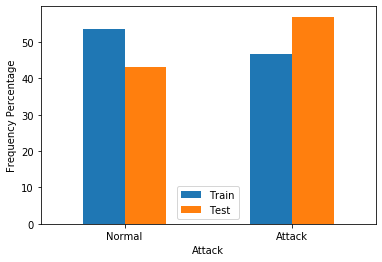

In [15]:
# Attack percentage in train and test datasets
pd.concat([(train.attack.value_counts()/train.shape[0])*100,
           (test.attack.value_counts()/test.shape[0])*100], axis = 1).plot(kind = 'bar')
plt.legend(['Train','Test'])
plt.xlabel('Attack')
plt.xticks(ticks = (0,1), rotation = 0, labels = ('Normal', 'Attack'))
plt.ylabel('Frequency Percentage')
plt.show()

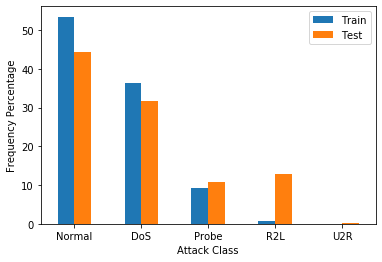

In [16]:
# Attack Classes percentage in train and test datasets
pd.concat([(train.attack_class.value_counts()/train.shape[0])*100,
           (test.attack_class.value_counts()/test.shape[0])*100], axis = 1).plot(kind = 'bar')
plt.legend(['Train','Test'])
plt.xticks(rotation = 0)
plt.xlabel('Attack Class')
plt.ylabel('Frequency Percentage')
plt.show()

In [17]:
# Getting Categorical and Continuous Features

cat_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'root_shell','is_host_login', 
            'is_guest_login', 'su_attempted', 'attack', 'attack_class']

nominal =  ['protocol_type', 'service', 'flag']
 
binary = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
 
cont_cols = ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 
           'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 
           'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 
           'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
           'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
           'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

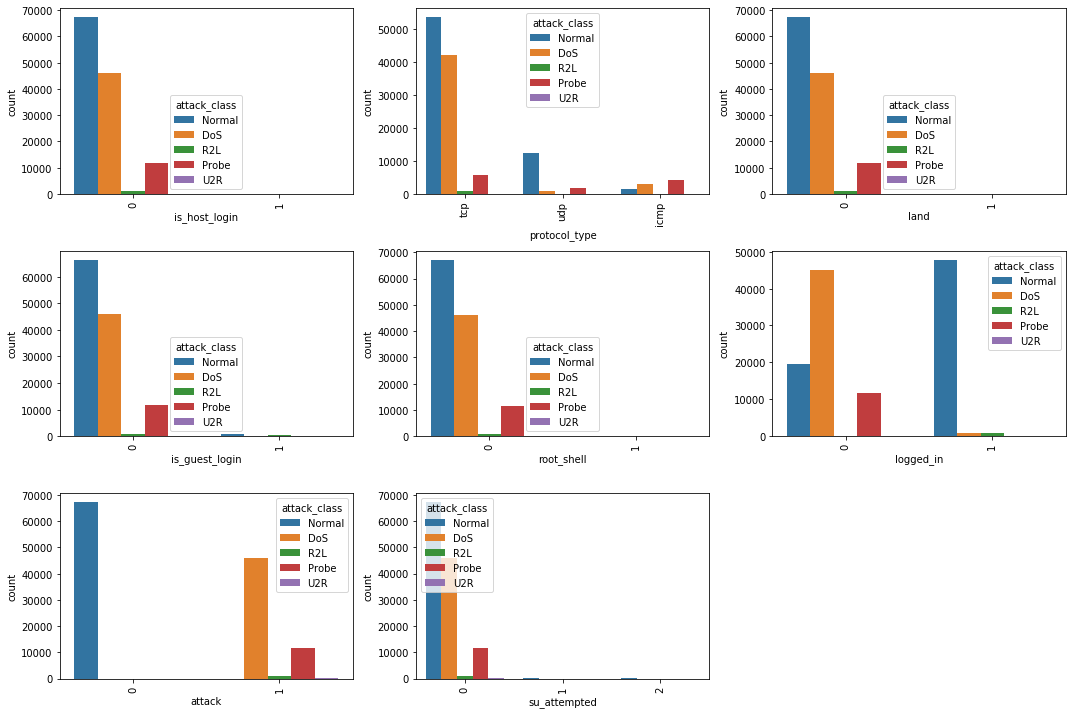

In [18]:
# Attack class across different categorical features
plt.figure(figsize = (15,10))
for a, b in enumerate(set(cat_cols).difference(['attack_class', 'service', 'flag'])):
    plt.subplot(3, 3, a+1)
    plt.subplots_adjust(hspace = 1)
    sns.countplot(x = b, data = train, hue = 'attack_class')
    plt.xticks(rotation = 90)
    plt.tight_layout()
plt.show()

#### Analysis:-
- root_shell =  the Dos attack is high when root_shell is not obtained.
- land = when source and destination IP addresses and port numbers are not equal then, Dos attack is higher
- is_host_login = Dos attcks are higher when the host is not logged in.
- protocol_type  = In TCP protocol , Dos Attacks are higher.
- is_guest_login = when the guest is not logged in the Dos attacks are high.
- activity = dos attacks are higher
- su_attempted = when suroot command is used, then Dos attcks are high


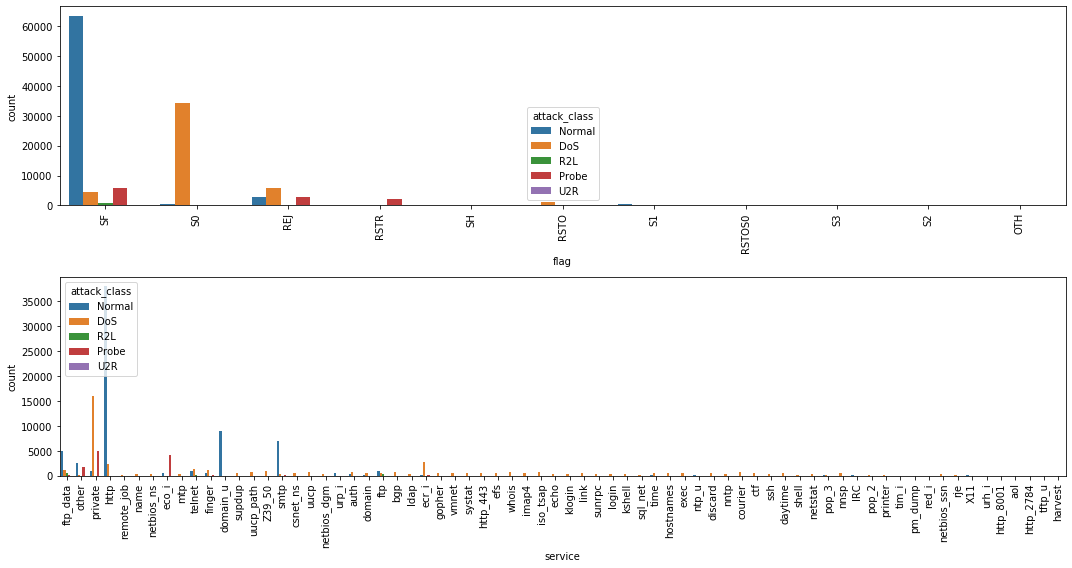

In [19]:
# Attack class across different service and flag
plt.figure(figsize = (15,8))
for a, b in enumerate(['flag', 'service']):
    plt.subplot(2, 1, a+1)
    plt.subplots_adjust(hspace = 1)
    sns.countplot(x = b, data = train, hue = 'attack_class')
    plt.xticks(rotation = 90)
    plt.tight_layout()
plt.show()

In [20]:
# Attack Classes across different continuous features
cont_plot = train.groupby('attack_class').mean().round().reset_index()
cont_plot

,attack_class,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,DoS,0.0,1176.0,169.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,19.0
1,Normal,169.0,13133.0,4330.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,20.0
2,Probe,2075.0,385680.0,181075.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,16.0
3,R2L,633.0,307727.0,81822.0,0.0,0.0,0.0,8.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,10.0
4,U2R,81.0,906.0,5142.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,4.0


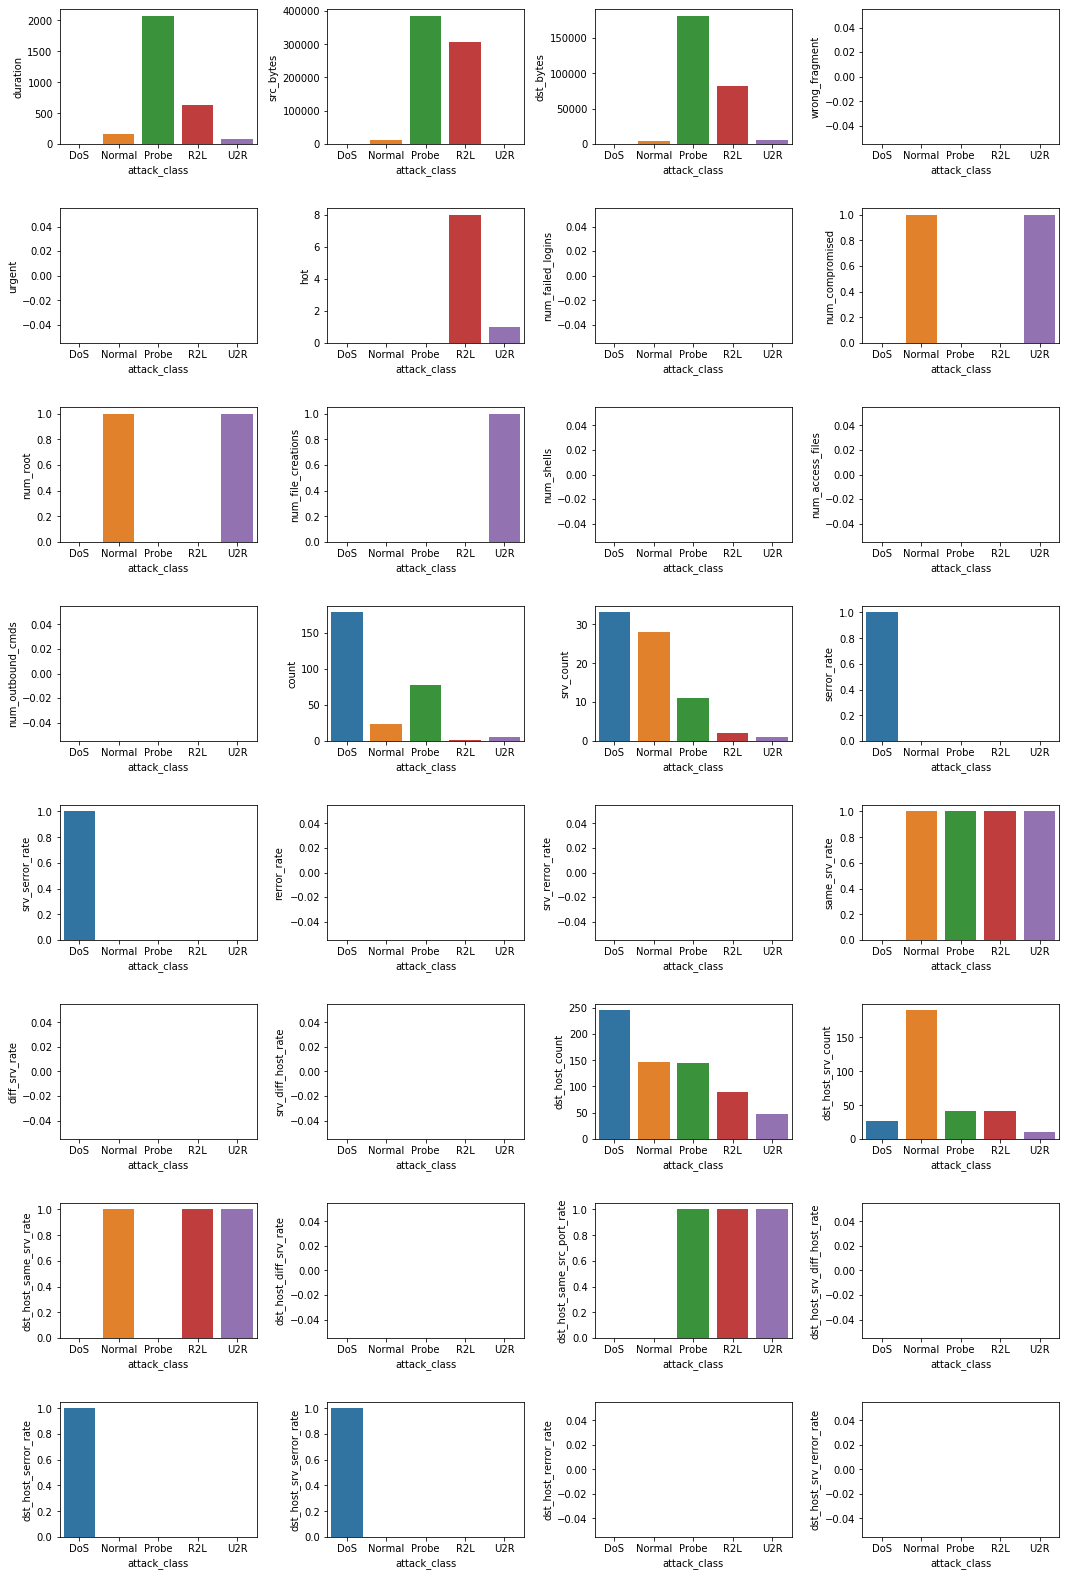

In [21]:
plt.figure(figsize = (15,22))
for a, b in enumerate(cont_cols):
    plt.subplot(8, 4, a+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = 'attack_class', y = b, data = cont_plot)
    plt.tight_layout()
plt.show() 

#### Analysis:-
- Probing (Prob) is high in<br>
 diff_srv_rate, dst_bytes, dst_host_diff_srv_rate, dst_host_rerror rate, dst_host_srv_diff_host_rate, dst_host_srv_rerror        rate, duration, rerror_rate, src_bytes, srv_diff_host_rate, srv_rerror_rate, dst_host_same_src_port_rate
- Dos attacks are high in<br>
count,dst_host_count,dst_host_serror_rate,dst_host_srv_serror_rate,serror_rate,srv_count,srv_serror_rate,wrong_fragment
- R2L is high in<br>
hot,num_failed_logins,same_srv_rate
- U2R is high in<br>
num_access_files,num_compormised, num_file_creations,num_root,num_shells,urgent

# Data Preparation 

### EDA

In [22]:
train[cont_cols].apply(continuous_summary).T.round(1)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
duration,125973.0,0.0,3.617247e+07,287.1,0.0,2604.5,6.783500e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,9590.6,4.290800e+04
src_bytes,125973.0,0.0,5.740179e+09,45566.7,44.0,5870331.2,3.446079e+13,0.0,0.0,0.0,0.0,0.0,44.0,276.0,848.0,1480.0,54540.0,1.379964e+09
dst_bytes,125973.0,0.0,2.491634e+09,19779.1,0.0,4021269.2,1.617061e+13,0.0,0.0,0.0,0.0,0.0,0.0,516.0,3375.8,8314.0,25519.0,1.309937e+09
wrong_fragment,125973.0,0.0,2.858000e+03,0.0,0.0,0.3,1.000000e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000e+00
urgent,125973.0,0.0,1.400000e+01,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000e+00
hot,125973.0,0.0,2.575000e+04,0.2,0.0,2.1,4.600000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,7.700000e+01
num_failed_logins,125973.0,0.0,1.540000e+02,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000e+00
num_compromised,125973.0,0.0,3.517800e+04,0.3,0.0,23.9,5.732000e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.479000e+03
num_root,125973.0,0.0,3.806800e+04,0.3,0.0,24.4,5.953000e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.468000e+03
num_file_creations,125973.0,0.0,1.596000e+03,0.0,0.0,0.5,2.000000e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.300000e+01


In [23]:
train[cat_cols].apply(categorical_summary)

,protocol_type,service,flag,land,logged_in,root_shell,is_host_login,is_guest_login,su_attempted,attack,attack_class
N,125973,125973,125973,125973.00,125973.00,125973.00,125973.0,125973.00,125973.00,125973.00,125973
NMISS,0,0,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0
MODE,tcp,http,SF,0.00,0.00,0.00,0.0,0.00,0.00,0.00,Normal
FREQ,102689,40338,74945,125948.00,76121.00,125804.00,125972.0,124786.00,125893.00,67343.00,67343
PERCENT,81.52,32.02,59.49,99.98,60.43,99.87,100.0,99.06,99.94,53.46,53.46


### Outliers

In [24]:
# Outlier Treatment
train[cont_cols] = train[cont_cols].apply(outlier_capping)
test[cont_cols] = test[cont_cols].apply(outlier_capping)

### Missing

In [25]:
# Columns containing all zeros or null
null_cols = train.columns[(train == 0).all()]
null_cols

Index(['wrong_fragment', 'urgent', 'num_failed_logins', 'num_root',
       'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds'],
      dtype='object')

In [26]:
# Dropping the column containing all zeros
train.drop(null_cols, axis = 1, inplace = True)
test.drop(null_cols, axis = 1, inplace = True)

In [27]:
# Update Continuous and cateforical columns list
cont_cols = list(set(cont_cols).difference(null_cols))
cat_cols = list(set(cat_cols).difference(null_cols))

In [28]:
# Checking missing values in train dataset
train.isna().sum().sum()

0

In [29]:
# Checking missing values in test dataset
test.isna().sum().sum()

0

### Encoding Categorical Variables - Dummy

In [30]:
train[cat_cols].nunique().sort_values()

is_host_login      2
land               2
is_guest_login     2
root_shell         2
logged_in          2
attack             2
protocol_type      3
su_attempted       3
attack_class       5
flag              11
service           70
dtype: int64

In [31]:
# No of unique values in 'service' is much greater, so dropping it
train.drop('service', axis = 1, inplace = True)
test.drop('service', axis = 1, inplace = True)

In [32]:
cat_cols.remove('service')

In [33]:
for i in train.select_dtypes(include='object').columns:
    if train[i].nunique() > 2:
        print(i, '\t', train[i].nunique(), '\t', train[i].unique())

protocol_type 	 3 	 ['tcp' 'udp' 'icmp']
flag 	 11 	 ['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']
attack_class 	 5 	 ['Normal' 'DoS' 'R2L' 'Probe' 'U2R']


In [34]:
# Creating Dummy Variables for nominal features
for_dummy = ['protocol_type', 'flag']
for col in for_dummy:
    train = dummy_var(train, col)
    test = dummy_var(test, col)

In [35]:
# Encoding target variable 'attack_class' using Label Encoder
target_map = {'Normal':'0', 'DoS':'1', 'Probe':'2', 'R2L':'3', 'U2R':'4'}
train['attack_class'] = train['attack_class'].apply(lambda x: target_map[x])
test['attack_class'] = test['attack_class'].apply(lambda x: target_map[x])

train['attack_class'] = train['attack_class'].astype('int64')
test['attack_class'] = test['attack_class'].astype('int64')

### summary

In [36]:
train.select_dtypes(include='number').apply(continuous_summary).T.round(1)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
duration,125973.0,0.0,19111663.6,151.7,0.0,1095.9,1200913.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,9590.2,9590.6
src_bytes,125973.0,0.0,129688967.0,1029.5,44.0,6137.9,37673835.8,0.0,0.0,0.0,0.0,0.0,44.0,276.0,848.0,1480.0,54540.0,54540.0
dst_bytes,125973.0,0.0,169070700.0,1342.1,0.0,3804.3,14472652.9,0.0,0.0,0.0,0.0,0.0,0.0,516.0,3375.8,8314.0,25519.0,25519.0
land,125973.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
hot,125973.0,0.0,6238.0,0.0,0.0,0.4,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
logged_in,125973.0,0.0,49852.0,0.4,0.0,0.5,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
num_compromised,125973.0,0.0,1286.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
root_shell,125973.0,0.0,169.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
su_attempted,125973.0,0.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
is_host_login,125973.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
train.select_dtypes(include='object').apply(categorical_summary).T

,0,1,2,3,4,5,6,7,8,9,...,125963,125964,125965,125966,125967,125968,125969,125970,125971,125972


### correlation

In [38]:
correlation = train.corr()
correlation.to_excel('correlation.xlsx')

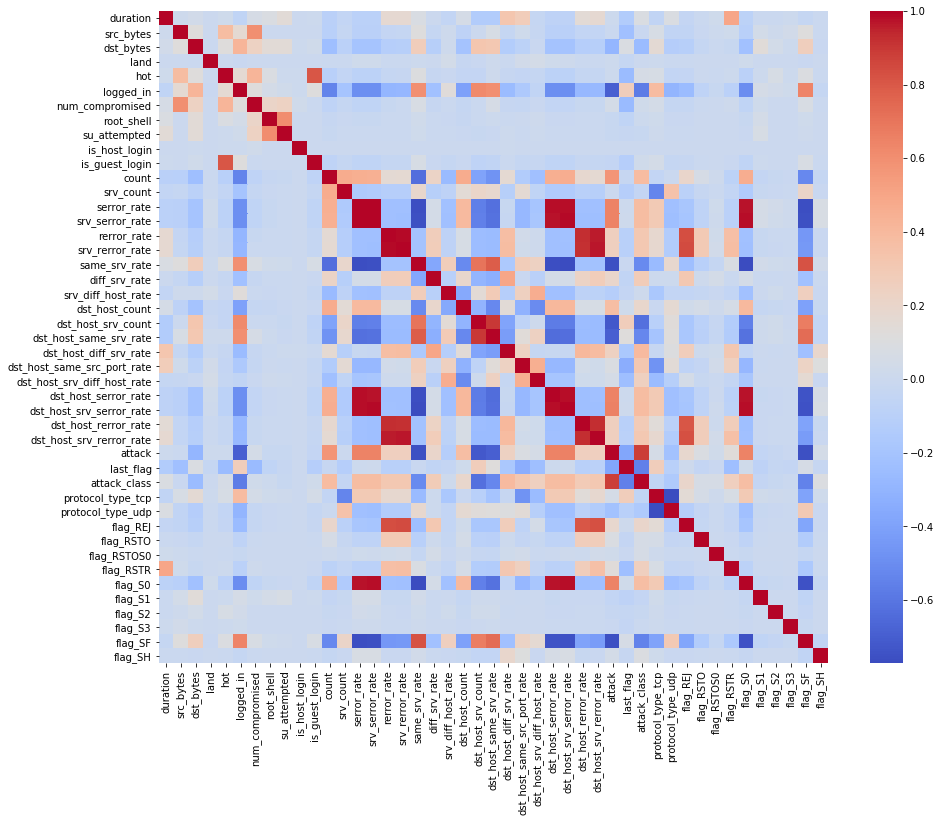

In [39]:
# Plotting correlation
plt.figure(figsize=(15, 12))
sns.heatmap(correlation, cmap='coolwarm')
plt.show()

In [40]:
train.head(2)

,duration,src_bytes,dst_bytes,land,hot,logged_in,num_compromised,root_shell,su_attempted,is_host_login,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Standardizing Data 

In [42]:
# all X features columns
features = train.columns.difference(['attack', 'attack_class'])

# new Standardized dataframe
traindata = pd.DataFrame(train[['attack', 'attack_class']])
testdata = pd.DataFrame(test[['attack', 'attack_class']])

#  Standardized features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
traindata[features] = pd.DataFrame(scaler.fit_transform(train[features]), columns = features)
testdata[features] = pd.DataFrame(scaler.transform(test[features]), columns =features)

In [43]:
traindata.head(2)

,attack,attack_class,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,...,rerror_rate,root_shell,same_srv_rate,serror_rate,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,su_attempted
0,0,0,-0.717047,-0.349683,-0.352792,-0.324063,-0.280282,-0.224532,0.069972,-0.782367,...,-0.374362,-0.036652,0.771283,-0.637209,-0.087734,-0.357788,-0.37456,-0.374432,-0.631929,-0.024437
1,0,0,-0.620984,0.482201,-0.352792,0.734343,2.736852,-0.387635,2.367737,-1.161030,...,-0.374362,-0.036652,-1.321428,-0.637209,-0.143942,-0.371789,-0.37456,-0.374432,-0.631929,-0.024437


# Feature Selection

In [45]:
# Separating features (X-variables) & Y(dependent) variable into 2 separate dataframe
features = traindata[traindata.columns.difference(['attack', 'attack_class'])]
target = traindata['attack']

### Recursive Feature Elimination

In [46]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Using RFE to get importance of each variable
rfe = RFE(estimator = RandomForestClassifier(random_state=42))
rfe.fit(features, target)

# Getting important features
rfe_cols = list(features.columns[rfe.support_])
print(rfe_cols)

['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 'dst_host_same_src_port_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'dst_host_srv_serror_rate', 'flag_SF', 'last_flag', 'logged_in', 'protocol_type_tcp', 'protocol_type_udp', 'same_srv_rate', 'src_bytes', 'srv_count', 'srv_serror_rate']


###  VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the model

In [47]:
# combining all important variables
combine_feature =  rfe_cols
combine_feature = list(set(combine_feature))
combine_feature.sort()
print('no. of combine features: ', len(combine_feature))
print(combine_feature)

no. of combine features:  21
['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 'dst_host_same_src_port_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'dst_host_srv_serror_rate', 'flag_SF', 'last_flag', 'logged_in', 'protocol_type_tcp', 'protocol_type_udp', 'same_srv_rate', 'src_bytes', 'srv_count', 'srv_serror_rate']


In [48]:
# High VIF means information in that variable has already been explained by other X variables present in the model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

model_param = 'attack ~ ' + ' + '.join(combine_feature)
print(model_param)

attack ~ count + diff_srv_rate + dst_bytes + dst_host_count + dst_host_diff_srv_rate + dst_host_rerror_rate + dst_host_same_src_port_rate + dst_host_same_srv_rate + dst_host_serror_rate + dst_host_srv_count + dst_host_srv_diff_host_rate + dst_host_srv_serror_rate + flag_SF + last_flag + logged_in + protocol_type_tcp + protocol_type_udp + same_srv_rate + src_bytes + srv_count + srv_serror_rate


In [49]:
# First taking all the vaiables and iteratively removing variable with higher VIF we got the final eqn as new_eqn

#dropped: dst_host_srv_serror_rate + srv_serror_rate + flag_SF + dst_host_same_srv_rate + same_srv_rate + protocol_type_tcp + 
#dst_host_serror_rate +

model_param = '''attack ~ count + diff_srv_rate + dst_bytes + dst_host_count + dst_host_diff_srv_rate + dst_host_rerror_rate + 
dst_host_same_src_port_rate + dst_host_srv_count + dst_host_srv_diff_host_rate + last_flag + logged_in + 
protocol_type_udp + src_bytes + srv_count'''

# separate the Y and X variables
y, X = dmatrices(model_param, data = traindata, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif.sort_values('VIF', ascending=False, inplace=True)
vif.head()

,Features,VIF
11,logged_in,3.614353
1,count,3.009256
8,dst_host_srv_count,2.949805
14,srv_count,2.452884
4,dst_host_count,1.960532


In [50]:
# All the features have less than 4 VIF Factor(low Multicollinearity). using these features for model building.
vif_cols = list(set(vif.Features).difference(['Intercept']))
vif_cols.sort()
print('numbers of selected features: ', len(vif_cols))
print(vif_cols)

numbers of selected features:  14
['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'last_flag', 'logged_in', 'protocol_type_udp', 'src_bytes', 'srv_count']


### Building logistic Regression Model

In [51]:
# get the model equation
formula_m1 = 'attack ~ ' + ' + '.join(vif_cols)
print(formula_m1)

attack ~ count + diff_srv_rate + dst_bytes + dst_host_count + dst_host_diff_srv_rate + dst_host_rerror_rate + dst_host_same_src_port_rate + dst_host_srv_count + dst_host_srv_diff_host_rate + last_flag + logged_in + protocol_type_udp + src_bytes + srv_count


In [52]:
# the model equation after dropping features with higher pvalue
import statsmodels.formula.api as smf

formula_m1 = '''attack ~ count + diff_srv_rate + dst_bytes + dst_host_count + dst_host_diff_srv_rate + dst_host_rerror_rate + 
dst_host_same_src_port_rate + dst_host_srv_count + dst_host_srv_diff_host_rate + last_flag + logged_in + protocol_type_udp + 
src_bytes + srv_count'''

# execute a model for the X variables
model1 = smf.logit( formula = formula_m1, data = traindata ).fit() 

# print the model summary stats 
print(model1.summary2())

Optimization terminated successfully.
         Current function value: 0.098645
         Iterations 11
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.857     
Dependent Variable:      attack              AIC:                 24883.2200
Date:                    2021-11-15 21:02    BIC:                 25029.3773
No. Observations:        125973              Log-Likelihood:      -12427.   
Df Model:                14                  LL-Null:             -87016.   
Df Residuals:            125958              LLR p-value:         0.0000    
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          11.0000                                            
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Inte

In [53]:
final_features = list(model1.pvalues.index.difference(['Intercept']))
print('length of final features:', len(final_features))
print(final_features)

length of final features: 14
['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'last_flag', 'logged_in', 'protocol_type_udp', 'src_bytes', 'srv_count']


In [54]:
trainout = pd.DataFrame(traindata['attack'])
trainout['predict_proba'] = model1.predict(traindata[final_features])
trainout.head()

,attack,predict_proba
0,0,0.205255
1,0,0.964209
2,1,0.998258
3,0,0.000036
4,0,0.000480


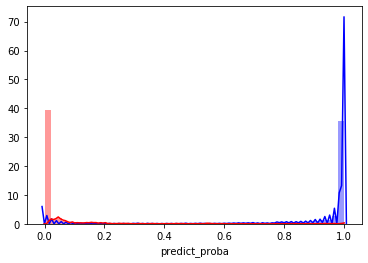

In [55]:
sns.distplot( trainout.loc[ trainout.attack == 1 , 'predict_proba'], color = 'b' )
sns.distplot( trainout.loc[ trainout.attack == 0 , 'predict_proba'], color = 'r' )
plt.show()

In [56]:
# declare empty dataframe
cm_scores = pd.DataFrame()

for iCutoff in np.arange(0, 1, 0.005):
    
    # do the predictions at the cutoff
    y_predict = np.where( trainout.predict_proba >= iCutoff, 1, 0 )
    
    # create the confusion matrix with predicted y
    cm = metrics.confusion_matrix( trainout.attack, y_predict )[::-1, ::-1]
    
    # get the sentivity + specificity at the cutoff
    Total = cm[0, 0]/cm.sum(axis = 1)[0] + cm[1, 1]/cm.sum(axis = 1)[1]
    
    # append the data row wise in the dataframe
    cm_scores = pd.concat( [cm_scores, pd.DataFrame([iCutoff, Total]).T ], axis = 0 )
    
cm_scores.columns = ['Cutoff', 'Score']
cm_scores.loc[ cm_scores.Score == cm_scores.Score.max(), 'Cutoff']

0    0.295
Name: Cutoff, dtype: float64

**taking 0.295 as cutoff**

In [57]:
lr_train_pred = model1.predict(traindata[final_features]).map(lambda x: 1 if x >= 0.295 else 0 )
lr_test_pred = model1.predict(testdata[final_features]).map(lambda x: 1 if x >= 0.295 else 0 )

In [58]:
print("The overall accuracy score for the Train Data is : ", accuracy_score(traindata['attack'], lr_train_pred))
print("The overall accuracy score for the Test Data  is : ", accuracy_score(testdata['attack'], lr_test_pred))

The overall accuracy score for the Train Data is :  0.9680328324323466
The overall accuracy score for the Test Data  is :  0.902235628105039


In [59]:
print('ROC AUC score of train data:', roc_auc_score(traindata['attack'], lr_train_pred))
print('ROC AUC score of test data:', roc_auc_score(testdata['attack'], lr_test_pred))

ROC AUC score of train data: 0.969628580189404
ROC AUC score of test data: 0.9018522063927406


In [60]:
# Getting classification metrics scores for training dataset
print(metrics.classification_report(traindata['attack'], lr_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     67343
           1       0.94      0.99      0.97     58630

    accuracy                           0.97    125973
   macro avg       0.97      0.97      0.97    125973
weighted avg       0.97      0.97      0.97    125973



In [61]:
# Getting classification metrics scores for testing dataset
print(metrics.classification_report(testdata['attack'], lr_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      9711
           1       0.92      0.90      0.91     12833

    accuracy                           0.90     22544
   macro avg       0.90      0.90      0.90     22544
weighted avg       0.90      0.90      0.90     22544



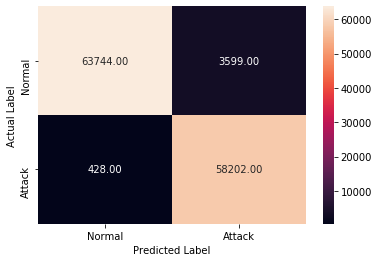

In [62]:
# confusion matrix of training dataset
confusion_matrix = metrics.confusion_matrix(traindata['attack'], lr_train_pred)
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', 
            xticklabels = ['Normal', 'Attack'], 
            yticklabels = ['Normal', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

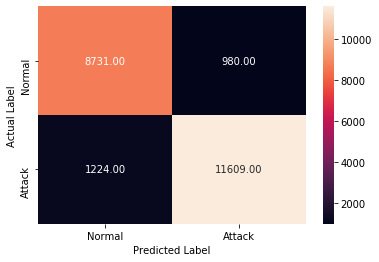

In [63]:
# confusion matrix of testing dataset
confusion_matrix = metrics.confusion_matrix(testdata['attack'], lr_test_pred)
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', 
            xticklabels = ['Normal', 'Attack'], 
            yticklabels = ['Normal', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [64]:
trainout = train[final_features]
trainout = train[['attack','attack_class']]

testout = test[final_features]
testout = test[['attack','attack_class']]

In [100]:
trainout['lr_attack'] = model1.predict(traindata[final_features]).map(lambda x: 1 if x >= 0.295 else 0 )
testout['lr_attack'] = model1.predict(testdata[final_features]).map(lambda x: 1 if x >= 0.295 else 0 )

# MODELS

In [66]:
final_features = ['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 
                  'dst_host_same_src_port_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'last_flag', 'logged_in', 
                  'protocol_type_udp', 'src_bytes', 'srv_count']

In [67]:
train_x, test_x, train_y, test_y = train_test_split(traindata[final_features], traindata['attack'], 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [68]:
# Writing output data into excel
output = pd.ExcelWriter('Network_Intrusion_output.xlsx')

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRFClassifier
from sklearn import svm

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [71]:
# Different models
models = []
models.append(('LR', LogisticRegression()))
models.append(('RFC', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('ADABC', AdaBoostClassifier()))
models.append(('ETC', ExtraTreeClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('XGBC', XGBRFClassifier()))

In [72]:
# evaluate each model in turn
names = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring='roc_auc', n_jobs=-1) 
    names.append(name)
    results.append(cv_results)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.993656 (0.000115)
RFC: 0.999995 (0.000002)
CART: 0.997398 (0.000272)
ADABC: 0.999034 (0.000156)
ETC: 0.995828 (0.000431)
GBC: 0.999914 (0.000033)
XGBC: 0.999822 (0.000021)


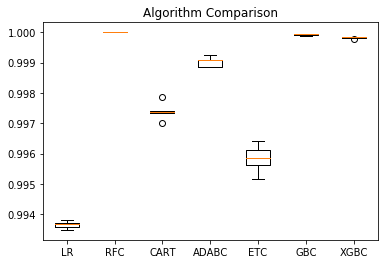

In [73]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [74]:
models_df = pd.DataFrame({'Model': names, 'Score': [round(r.mean()*100,4) for r in results]})
models_df.sort_values(by='Score', ascending=False, inplace=True, ignore_index=True)
models_df

,Model,Score
0,RFC,99.9995
1,GBC,99.9914
2,XGBC,99.9822
3,ADABC,99.9034
4,CART,99.7398
5,ETC,99.5828
6,LR,99.3656


# model

In [83]:
param = {'n_estimators' : [400,500,600],
         'max_depth' : [20,30,40]
        }
gscv_rf = GridSearchCV(estimator = RandomForestClassifier(random_state=42), 
                     param_grid= param,
                     scoring = 'roc_auc',
                     cv = 10,
                     n_jobs = -1,
                     verbose=5).fit(train_x, train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 41.9min finished


In [84]:
gscv_rf.best_estimator_

RandomForestClassifier(max_depth=30, n_estimators=500, random_state=42)

In [85]:
gscv_rf.best_score_

0.9999954083410143

In [86]:
rf = gscv_rf.best_estimator_
rf.fit(train_x, train_y)

# Making prediction on train and test data
rf_train_pred = rf.predict(train_x)
rf_test_pred = rf.predict(test_x)

# Calculating log loss
print("Log Loss train: ", metrics.log_loss(train_y, rf.predict_proba(train_x)))
print("Log Loss test: ", metrics.log_loss(test_y, rf.predict_proba(test_x)))

Log Loss train:  0.0013849214032726155
Log Loss test:  0.004374522826254269


In [87]:
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, rf_train_pred))
print("AUC      : ", metrics.roc_auc_score(train_y, rf_train_pred))
print("")
print("Test Dataset")
acc_rf = metrics.accuracy_score(test_y, rf_test_pred)
print("Accuracy : ", metrics.accuracy_score(test_y, rf_test_pred))
print("AUC      : ", metrics.roc_auc_score(test_y, rf_test_pred))

Model Performance
Train Dataset
Accuracy :  1.0
AUC      :  1.0

Test Dataset
Accuracy :  0.999126799322608
AUC      :  0.9991149961045814


In [90]:
# Getting classification metrics scores
print(metrics.classification_report(test_y, rf_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20083
           1       1.00      1.00      1.00     17709

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



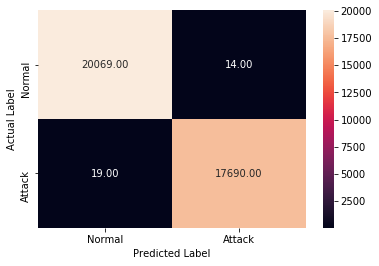

In [91]:
# confusion matrix for testing data
confusion_matrix = metrics.confusion_matrix(test_y, rf_test_pred, labels = [0,1])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', 
            xticklabels = ['Normal', 'Attack'], 
            yticklabels = ['Normal', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

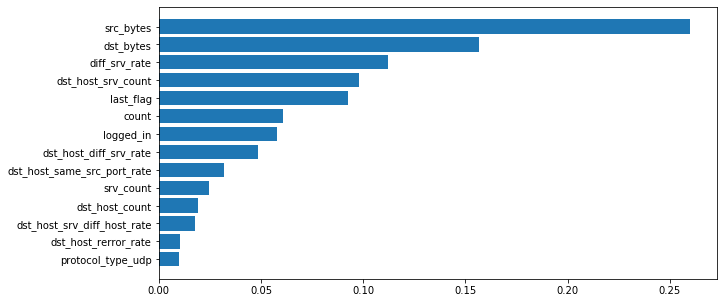

In [92]:
# Feature Impotance 
rf_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : rf.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

rf_fi.to_excel(output, 'Drivers_Binomial', startrow=2, startcol=1, index = False)
plt.figure(figsize=(10,5))
plt.barh(width = rf_fi.Importance, y = rf_fi.Features)
plt.show()

#### Evaluating model on test dataset

In [93]:
rf_testfinal_pred = rf.predict(testdata[final_features])

In [94]:
# Getting classification metrics scores
print(metrics.classification_report(testdata['attack'], rf_testfinal_pred))

              precision    recall  f1-score   support

           0       0.70      0.97      0.82      9711
           1       0.97      0.69      0.81     12833

    accuracy                           0.81     22544
   macro avg       0.84      0.83      0.81     22544
weighted avg       0.86      0.81      0.81     22544



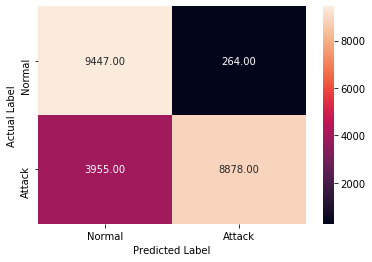

In [95]:
# confusion matrix for testing data
confusion_matrix = metrics.confusion_matrix(testdata['attack'], rf_testfinal_pred, labels = [0,1])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', 
            xticklabels = ['Normal', 'Attack'], 
            yticklabels = ['Normal', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [98]:
trainout['rf_attack'] = rf.predict(traindata[final_features])
testout['rf_attack'] = rf.predict(testdata[final_features])

# Predictive Model 
## Multinomial Classification
### Attack type prediction



#### Getting Train and Test Datasets

In [101]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder

In [102]:
train_x, test_x, train_y, test_y = train_test_split(traindata[final_features], traindata['attack_class'], 
                                                    test_size = 0.3, 
                                                    random_state = 42)

#### Data Sampling

In [103]:
# Using RandomOverSampler for rebalancing the data 
print('Original dataset shape {}'.format(Counter(train_y)))

ros = RandomOverSampler(random_state = 42, sampling_strategy = 'auto')
train_x, train_y = ros.fit_resample(train_x, train_y)

print('Oversampled dataset shape {}'.format(Counter(train_y)))

Original dataset shape Counter({0: 47260, 1: 32102, 2: 8116, 3: 668, 4: 35})
Oversampled dataset shape Counter({0: 47260, 1: 47260, 2: 47260, 3: 47260, 4: 47260})


In [104]:
# Different models
models = []
models.append(('LR', LogisticRegression()))
models.append(('RFC', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('ADABC', AdaBoostClassifier()))
models.append(('ETC', ExtraTreeClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('XGBC', XGBRFClassifier()))

In [105]:
# evaluate each model in turn
names = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold,  n_jobs=-1)
    names.append(name)
    results.append(cv_results)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.928532 (0.002733)
RFC: 0.999691 (0.000034)
CART: 0.999353 (0.000137)
ADABC: 0.634321 (0.075698)
ETC: 0.998709 (0.000176)
GBC: 0.998041 (0.000208)
XGBC: 0.995375 (0.000370)


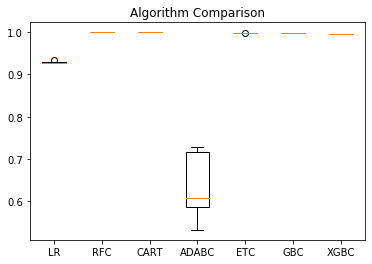

In [106]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [107]:
models_df = pd.DataFrame({'Model': names, 'Score': [round(r.mean()*100,4) for r in results]})
models_df.sort_values(by='Score', ascending=False, inplace=True, ignore_index=True)
models_df

,Model,Score
0,RFC,99.9691
1,CART,99.9353
2,ETC,99.8709
3,GBC,99.8041
4,XGBC,99.5375
5,LR,92.8532
6,ADABC,63.4321


# model

In [108]:
param = { 'n_estimators' : [400,500,600,700],
         'max_depth' : [20,30,40]
        }
gscv_rf = GridSearchCV(estimator = RandomForestClassifier(random_state=42), 
                     param_grid = param,
                     cv = 10,
                     n_jobs = -1,
                     verbose=5).fit(train_x, train_y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 72.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 169.1min finished


In [109]:
gscv_rf.best_estimator_

RandomForestClassifier(max_depth=30, n_estimators=500, random_state=42)

In [110]:
gscv_rf.best_score_

0.9997079983072366

In [111]:
rf_multi = gscv_rf.best_estimator_
rf_multi.fit(train_x, train_y)

# Making prediction on train and test data
rf_train_pred = rf_multi.predict(train_x)
rf_test_pred = rf_multi.predict(test_x)

# Calculating log loss
print("Log Loss train: ", metrics.log_loss(train_y, rf_multi.predict_proba(train_x)))
print("Log Loss test: ", metrics.log_loss(test_y, rf_multi.predict_proba(test_x)))

Log Loss train:  0.00041744840963254843
Log Loss test:  0.005793477618873462


In [112]:
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, rf_train_pred))
print("AUC      : ", metrics.roc_auc_score(train_y, rf_multi.predict_proba(train_x), multi_class = 'ovr'))
print("")
print("Test Dataset")
print("Accuracy : ", metrics.accuracy_score(test_y, rf_test_pred))
print("AUC      : ", metrics.roc_auc_score(test_y, rf_multi.predict_proba(test_x), multi_class = 'ovr'))

Model Performance
Train Dataset
Accuracy :  1.0
AUC      :  1.0

Test Dataset
Accuracy :  0.9987034292972058
AUC      :  0.9999800029920378


In [115]:
# Getting classification metrics scores for testing
print(metrics.classification_report(test_y, rf_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20083
           1       1.00      1.00      1.00     13825
           2       1.00      1.00      1.00      3540
           3       0.97      0.98      0.98       327
           4       0.75      0.71      0.73        17

    accuracy                           1.00     37792
   macro avg       0.94      0.94      0.94     37792
weighted avg       1.00      1.00      1.00     37792



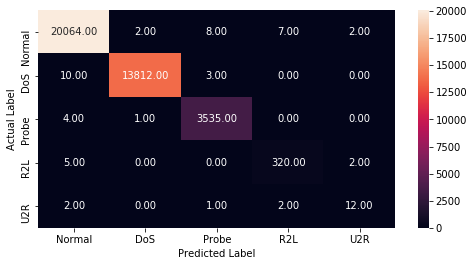

In [116]:
# Confusion Matrix for testing
plt.figure(figsize = (8,4))
confusion_matrix = metrics.confusion_matrix(test_y, rf_test_pred, labels = [0,1,2,3,4])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f',
            xticklabels = ['Normal','DoS', 'Probe', 'R2L', 'U2R'],
            yticklabels = ['Normal','DoS', 'Probe', 'R2L', 'U2R'] )
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [117]:
test_y.value_counts()

0    20083
1    13825
2     3540
3      327
4       17
Name: attack_class, dtype: int64

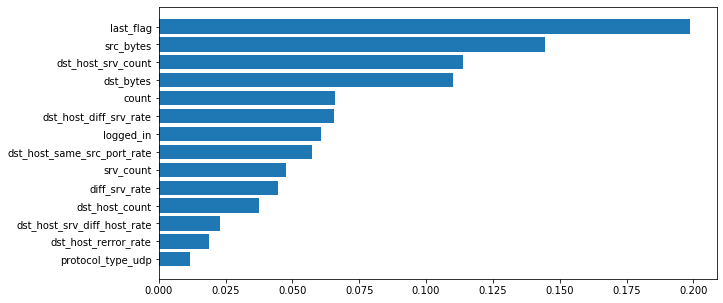

In [118]:
# Feature Impotance 
rf_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : rf_multi.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

rf_fi.to_excel(output, 'Drivers_Multinomial', startrow=2, startcol=1, index = False)
plt.figure(figsize=(10,5))
plt.barh(width = rf_fi.Importance, y = rf_fi.Features)
plt.show()

#### Evaluating model on test dataset

In [119]:
rf_testfinal_pred = rf_multi.predict(testdata[final_features])

In [120]:
# Getting classification metrics scores for testing
print(metrics.classification_report(testdata['attack_class'], rf_testfinal_pred))

              precision    recall  f1-score   support

           0       0.68      0.97      0.80     10004
           1       0.96      0.82      0.88      7167
           2       0.74      0.63      0.68      2421
           3       0.73      0.01      0.02      2885
           4       0.35      0.24      0.28        67

    accuracy                           0.76     22544
   macro avg       0.69      0.54      0.53     22544
weighted avg       0.78      0.76      0.71     22544



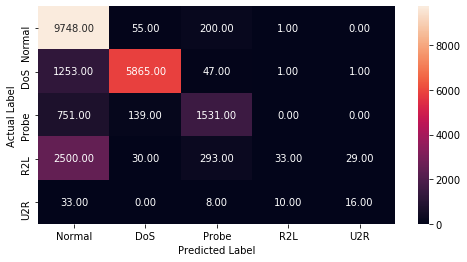

In [121]:
# Confusion Matrix for testing
plt.figure(figsize = (8,4))
confusion_matrix = metrics.confusion_matrix(testdata['attack_class'], rf_testfinal_pred, labels = [0,1,2,3,4])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f',
            xticklabels = ['Normal','DoS', 'Probe', 'R2L', 'U2R'],
            yticklabels = ['Normal','DoS', 'Probe', 'R2L', 'U2R'] )
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [122]:
trainout['rf_attack_class'] = rf_multi.predict(traindata[final_features])
testout['rf_attack_class'] = rf_multi.predict(testdata[final_features])

In [123]:
trainout.to_excel(output, 'training', startrow=2, startcol=0, index = False)
testout.to_excel(output, 'testing', startrow=2, startcol=0, index = False)

In [124]:
output.save()